In [1]:
using CSV
using DataFrames
using Optim
using Distributions
using LinearAlgebra   
using Plots
using SymPy

In [2]:
# Load Data 
particle_data = CSV.read("particles.csv", DataFrame)

Row,shower,pdg,kinetic_energy,x,y,z,time,weight
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,0,22,2.68063,-2511.15,5536.2,0.0,1.13973e-5,1.0
2,0,22,1.16594,-1897.83,3594.58,0.0,1.55407e-5,1.0
3,0,22,1.69784,-1689.12,3238.18,0.0,1.28297e-5,1.0
4,0,22,8.22074,-1520.27,2680.62,0.0,1.60523e-5,1.0
5,0,22,1.2727,-1450.41,2461.66,0.0,1.68368e-5,1.0
6,0,22,1.35689,-2470.07,5260.24,0.0,5.77628e-6,1.0
7,0,22,1.16295,-2714.79,5966.96,0.0,7.03563e-6,1.0
8,0,22,1.04626,-2740.38,6047.79,0.0,7.90808e-6,1.0
9,0,22,6.21258,-1973.2,4061.56,0.0,1.15843e-5,1.0


In [4]:
#= # Function to calculate the Cartesian distance between two points in 3D space
function cartesian_distance(x1, y1, z1, x2, y2, z2)
    return sqrt((x2 - x1)^2 + (y2 - y1)^2 + (z2 - z1)^2)
end

x1, y1, z1 = 5.82690291372798, 2.651239329640523, -0.7696777502523529 # Coordinates of the first point
x2, y2, z2 = 2.3913633278814264, 1.8136136167654868, −0.5130112708971727  # Coordinates of the second point

# Calculate the distance
distance = cartesian_distance(x1, y1, z1, x2, y2, z2)
println("The distance between the points is: $distance")

# Calculate t0
c = 299792 # km/s
t0 = distance/c
println("The value for t0 is: $t0") =#

The distance between the points is: 3.545479764772703
The value for t0 is: 1.1826465565367665e-5


In [5]:
normal_vector = [0.45217398524533681 -0.3661629880519191 0.81330397346148509]
x_axis = [0.0 -0.91184756344828699 -0.41052895273466672]
y_axis = [0.89192975455881607 0.18563051261662877 -0.41231374670066206]

rotation_matrix = vcat(x_axis, y_axis, normal_vector)

coords = hcat(particle_data.x, particle_data.y, particle_data.z)

rotated_positions = inv(rotation_matrix) * transpose(coords)

transposed_positions = transpose(rotated_positions)

df_rotated_positions = DataFrame(transposed_positions, [:x, :y, :z])
df_kinetic_energy = DataFrame(kinetic_energy = particle_data.kinetic_energy)

df_rotated_positions[!, :kinetic_energy] = df_kinetic_energy[!, :kinetic_energy]

println(df_rotated_positions)

sqrt_total_energy = sum(sqrt.(particle_data.kinetic_energy))

weights = sqrt.(df_rotated_positions.kinetic_energy) ./ sqrt_total_energy

df_rotated_positions[!, :weighted_x] = df_rotated_positions.x .* weights
df_rotated_positions[!, :weighted_y] = df_rotated_positions.y .* weights
df_rotated_positions[!, :weighted_z] = df_rotated_positions.z .* weights

weighted_x = sum(df_rotated_positions[!, :weighted_x])
weighted_y = sum(df_rotated_positions[!, :weighted_y])
weighted_z = sum(df_rotated_positions[!, :weighted_z])

println(weighted_x)
println(weighted_y)
println(weighted_z)

2171×4 DataFrame
  Row │ x            y            z            kinetic_energy 
      │ Float64      Float64      Float64      Float64        
──────┼───────────────────────────────────────────────────────
    1 │  4937.9       3317.47     -1251.75            2.68063
    2 │  3206.11      2397.8       -702.978           1.16594
    3 │  2888.23      2141.32      -641.715           1.69784
    4 │  2390.93      1883.86      -481.14            8.22074
    5 │  2195.62      1779.51      -419.539           1.2727
    6 │  4691.76      3228.79     -1154.83            1.35689
    7 │  5322.11      3583.12     -1345.76            1.16295
    8 │  5394.2       3621.46     -1368.58            1.04626
    9 │  3622.63      2553.21      -864.582           6.21258
   10 │  3609.62      2581.78      -844.487           2.03347
   11 │  4510.64      3080.46     -1120.92            4.40326
   12 │  3352.58      2441.7       -764.646           1.0709
   13 │  4376.5       2966.54     -1097.62          

In [ ]:
# new_z = (-normal_vector[1]*rotated_positions[1,:]-normal_vector[2]*rotated_positions[2,:])/normal_vector[3]

In [6]:
a = 4.823e-4 / 1e9  # in s/m^2
b = 19.41 / 1e9     # in seconds (s)
sigma = 83.5  # in meters (m)
c = 299792458  # Speed of light in meters per second (m/s)
#t0 = 2.8612842910494837e-5  # Initial time in seconds using intecept 
t0 = 1.1826465565367665e-5 # Initial time in seconds using mean position of particles 

initial_position = [5826.90291372798, 2651.239329640523, -769.6777502523529]
pos = [-1904.2410053751477, -753.5013903260498, 719.4652218340803]
core = [2391.3633278814264, 1813.6136167654868, -513.0112708971727]

zenith_rad = deg2rad(180 -99.99732787664736)
azimuth_rad = deg2rad(203.76835088101396)
direction_vector = (
    xdir = sin(zenith_rad) * cos(azimuth_rad),
    ydir = sin(zenith_rad) * sin(azimuth_rad),
    zdir = cos(zenith_rad)
)

println("Direction vector: $direction_vector")

function solved_R(pos, core, direction_vector)
       
    if all(pos .== values(core))
            return 0 
    end 
    
    norm((pos .- values(core))sin(acos(dot(normalize((pos .- values(core))), direction_vector))))
end

# println(rotated_positions[:,1])

R = solved_R(rotated_positions[:,1], core, direction_vector)
# println(norm(R))
println("R = $R")

function delta_t(a,b,sigma,R)
    return a * R^2 + b * (1 - exp(-R^2 / (2 * sigma^2)))
end

delta_t_val = delta_t(a,b,sigma,R)

println("∆t = $delta_t_val")

dot_product = dot((pos .-values(core)),direction_vector)

println("dot_product: $dot_product")
println("dot_product / c: $(dot_product / c)")

function expected_signal_time(t0, pos, core, a, b, sigma, direction_vector)
    c = 299792458
    R = solved_R(pos, core, direction_vector) 
    delta_t_val = delta_t(a,b,sigma,R)
    dot_product = dot((pos .-values(core)),direction_vector)
    return t0 + (dot_product / c) + delta_t_val
end

expected_time = []

# println(length(rotated_positions)/3)

for i in eachcol(rotated_positions)
    pos = i
    println(pos)
    signal_time = expected_signal_time(t0, pos, core, a, b, sigma, direction_vector)
    push!(expected_time, signal_time)
    println("Iteration $i - pos: $pos, signal_time: $signal_time")
end

println("expected_time = $expected_time")




Direction vector: (xdir = -0.9012861721003251, ydir = -0.39692001113966635, zdir = 0.17360224865372598)
R = 412.1434539843738
∆t = 1.0133445243558633e-7
dot_product: 5104.468794140967
dot_product / c: 1.7026675147848336e-5
[4937.898831399255, 3317.4699045433363, -1251.7517847346414]
Iteration [4937.898831399255, 3317.4699045433363, -1251.7517847346414] - pos: [4937.898831399255, 3317.4699045433363, -1251.7517847346414], signal_time: 1.8531139329578719e-6
[3206.1118760192994, 2397.799014946747, -702.9784074801103]
Iteration [3206.1118760192994, 2397.799014946747, -702.9784074801103] - pos: [3206.1118760192994, 2397.799014946747, -702.9784074801103], signal_time: 8.53273988708275e-6
[2888.2283790734637, 2141.3214473762905, -641.7146527540973]
Iteration [2888.2283790734637, 2141.3214473762905, -641.7146527540973] - pos: [2888.2283790734637, 2141.3214473762905, -641.7146527540973], signal_time: 9.83968849156989e-6
[2390.9254522092574, 1883.8630647238224, -481.14035349487864]
Iteration [239

Excessive output truncated after 554074 bytes.

4.6644148654757155e-6
0.001896009896510855
2.4859783399410016e-5


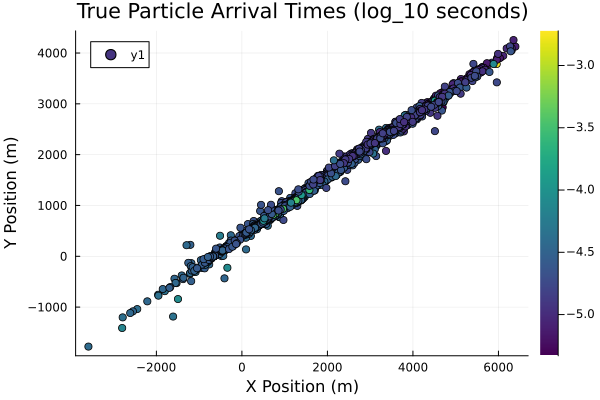

In [7]:
min_time = minimum(particle_data.time)
max_time = maximum(particle_data.time)
average_time = mean(particle_data.time)
normalized_time = (particle_data.time .- min_time) ./ (max_time - min_time)

println(min_time)
println(max_time)
println(average_time)

#scatter(rotated_positions[1, :], rotated_positions[2, :], marker_z=particle_data.time, color=:viridis, clims=(4.6644148654757155e-6, 0.001896009896510855), xlabel="X Position", ylabel="Y Position", title="True Particle Arrival Times")
scatter(rotated_positions[1, :], rotated_positions[2, :], marker_z=log10.(particle_data.time), color=:viridis, xlabel="X Position (m)", ylabel="Y Position (m)", title="True Particle Arrival Times (log_10 seconds)")

#= scatter!((-1904,-753))
scatter!((2485.30829674464,1867.8751468942435)) =#

# savefig("true_particle_arrival_times.png")

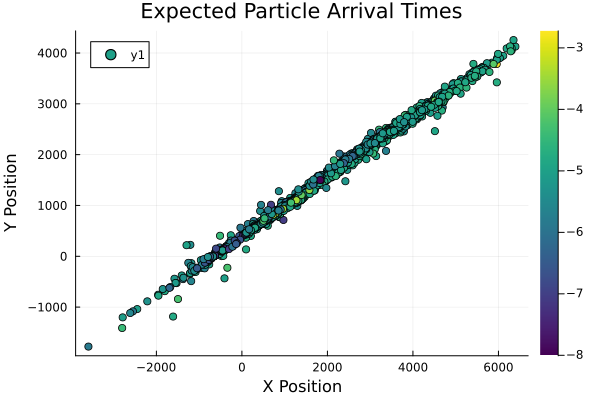

In [8]:
scatter(rotated_positions[1, :], rotated_positions[2, :], marker_z=log10.(abs.(particle_data.time - expected_time)), color=:viridis, xlabel="X Position", ylabel="Y Position", title="Expected Particle Arrival Times")

In [ ]:
histogram(abs.((particle_data.time .- t0) - expected_time)./(particle_data.time .- t0))

In [ ]:
histogram(particle_data.time .- t0)

In [ ]:
#data time
minimum(expected_time) 

# Count and print all negative values in expected_time
negatives = 0

for time in expected_time
    if time < 0
        println(time)
        negatives += 1
    end
end

println("# of negatives: $negatives")

In [ ]:
#= function solved_R(pos, core, direction_vector)
       
        if all(pos .== values(core))
                return 0 
        end 
        
        norm((pos .- values(core))sin(acos(dot(normalize((pos .- values(core))), direction_vector))))
end

println(rotated_positions[:,1])

R = solved_R(rotated_positions[:,1], core, direction_vector)
# println(norm(R))
println("R = $R") =#

In [ ]:
#= function std_dev_function(R)
    return 2.92 + 3.77e-4 * R^2  # σt(Ri) in ns
end

function likelihood_timing(particle_data, params)
    t0, xc, yc, zc, n1, n2, n3, c, a0, a1, a2 = params
    xc_vector = [xc, yc, zc]
    n_vector = [n1, n2, n3]
    log_likelihood = 0.0
    for row in eachrow(particle_data)
        x_pos = [row.x, row.y, row.z]  
        R = norm(x_pos .- xc_vector)
        sigma_t = std_dev_function(R)
        t_expected = expected_signal_time(x_pos, t0, xc_vector, n_vector, c, a0, a1, a2)
        log_likelihood += logpdf(Normal(t_expected, sigma_t), row.observed_time)
    end
    return -log_likelihood  
end =#

In [ ]:
#= particle_data = DataFrame(x = [1.0, 2.0, 3.0], y = [1.0, 2.0, 3.0], z = [1.0, 2.0, 3.0], observed_time = [10.0, 20.0, 30.0])

params = [t0, 5.0, 5.0, 5.0, direction_vector.xdir, direction_vector.ydir, direction_vector.zdir, c, 4.823e-4, 19.41, 83.5]

log_likelihood = likelihood_timing(particle_data, params)
println("Log-likelihood: $log_likelihood") =#

In [ ]:
#= function gradient_likelihood(particle_data, params)
    gradients = zeros(length(params))
    epsilon = 1e-5
    for i in 1:length(params)
        params_eps = copy(params)
        params_eps[i] += epsilon
        grad = (likelihood_timing(particle_data, params_eps) - likelihood_timing(particle_data, params)) / epsilon
        gradients[i] = grad
    end
    return gradients
end =#

In [ ]:
#= num_epochs = 20
errors = Float64[] 

learning_rate = 0.01

for epoch in 1:num_epochs

    current_error = likelihood_timing(particle_data, params)
    
    push!(errors, current_error)
    
    println("Epoch $epoch, Error: $current_error")
    
    gradients = gradient_likelihood(particle_data, params)
    
    for i in 1:length(params)
        params[i] -= learning_rate * gradients[i]
    end
end

training_data = DataFrame(epoch = 1:num_epochs, error = errors)
 =#

In [ ]:
#= # Plot
plot(training_data.epoch, training_data.error, marker = :circle, linestyle = :solid, color = :blue, xlabel = "Epoch", ylabel = "Error", title = "Error vs. Epochs", grid = true)
 =#